In [1]:
import os
import pandas as pd
import numpy as np
np.random.seed(42)


# Get a list of all files in the current working directory
files = os.listdir()
print(files)

['T_a1_new.csv', 'T_a2_new.csv', 'T_a3_new.csv', 'T_a4_new.csv', 'T_a6_new.csv', 'T_a5_new.csv', 'T_L2_new.csv', 'T_L3_new.csv', 'T_L4_new.csv', 'T_L6_new.csv', 'T_L5_new.csv', 'T_L1_new.csv', 'T_LS1_new.csv', 'T_LS3_new.csv', 'T_LS4_new.csv', 'T_LS2_new.csv', 'T_LS5_new.csv', 'T_LS6_new.csv', 'T_S1_new.csv', 'T_S2_new.csv', 'T_S3_new.csv', 'T_S4_new.csv', 'T_S6_new.csv', 'T_S5_new.csv', 'X_a2_new.csv', 'X_a1_new.csv', 'X_a3_new.csv', 'X_a4_new.csv', 'X_a5_new.csv', 'X_a6_new.csv', 'X_L2_new.csv', 'X_L1_new.csv', 'X_L5_new.csv', 'X_L4_new.csv', 'X_L3_new.csv', 'X_L6_new.csv', 'X_LS1_new.csv', 'X_LS3_new.csv', 'X_LS2_new.csv', 'X_LS6_new.csv', 'X_LS4_new.csv', 'X_LS5_new.csv', 'X_S1_new.csv', 'X_S2_new.csv', 'X_S3_new.csv', 'X_S4_new.csv', 'X_S5_new.csv', 'X_S6_new.csv', 'Last_Proj.ipynb', '.ipynb_checkpoints', 'X_300_Fault Classification.ipynb', 'FC_Classifier.h5', 'aemodel_ind.h5', 'GANs.ipynb', 'Last_Proj-Copy1.ipynb']


## Using Torque Variable

### Individual Batches

#### Batch 1

In [2]:
col_list = ['rod_1','rod_2','rod_3','rod_4','rod_5','rod_6','rod_7','rod_8','rod_9','rod_10']

healthy_1 = pd.read_csv('T_a1_new.csv',header=None, names=col_list)
short_fault_1 = pd.read_csv('T_S1_new.csv',header=None, names=col_list)
step_fault_1 = pd.read_csv('T_LS1_new.csv',header=None, names=col_list)
ramp_fault_1 = pd.read_csv('T_L1_new.csv',header=None, names=col_list)

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Load and preprocess data
healthy_1=np.array(healthy_1)
X_train_ind = scaler.fit_transform(healthy_1[0:int(0.7*len(healthy_1)),:])
X_test_ind_a = scaler.transform(healthy_1[int(0.7*len(healthy_1)):,:])
X_test_ind_S = scaler.transform(np.array(short_fault_1))
X_test_ind_LS = scaler.transform(np.array(step_fault_1))
X_test_ind_L = scaler.transform(np.array(ramp_fault_1))

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Define the model
input_dim = X_train_ind.shape[1]
latent_dim = 2
AE_model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(input_dim,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(latent_dim, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

# Compile the model
AE_model.compile(optimizer='adam', loss='mse')


In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint
# define the checkpoint filepath
checkpoint_filepath = 'aemodel_ind.h5'

# create the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False
)

In [6]:
AE_model.fit(X_train_ind, X_train_ind, epochs=6, batch_size=64, validation_split=0.2, callbacks = [checkpoint])

Epoch 1/6
4375/4375 [==============================] - 6s 1ms/step - loss: 0.0289 - val_loss: 0.0117
Epoch 2/6
4375/4375 [==============================] - 5s 1ms/step - loss: 0.0052 - val_loss: 0.0111
Epoch 3/6
4375/4375 [==============================] - 5s 1ms/step - loss: 0.0050 - val_loss: 0.0107
Epoch 4/6
4375/4375 [==============================] - 5s 1ms/step - loss: 0.0050 - val_loss: 0.0106
Epoch 5/6
4375/4375 [==============================] - 5s 1ms/step - loss: 0.0049 - val_loss: 0.0106
Epoch 6/6
4375/4375 [==============================] - 5s 1ms/step - loss: 0.0049 - val_loss: 0.0106


4688/4688 [==============================] - 3s 606us/step
Number of anomalies: 7500


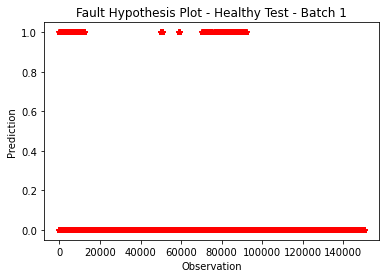

In [7]:
# Evaluate the model
X_pred = AE_model.predict(X_test_ind_a)
mse = np.mean(np.power(X_test_ind_a - X_pred, 2), axis=1)
threshold = np.percentile(mse, 95)
anomalies = np.where(mse > threshold)[0]
print('Number of anomalies:', len(anomalies))

# Predict Fault
predictions = np.zeros_like(mse)
predictions[mse > threshold] = 1

# Plot Hypothesis Curve
import matplotlib.pyplot as plt
plt.plot(predictions, 'r*')
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('Fault Hypothesis Plot - Healthy Test - Batch 1')
plt.show()

4688/4688 [==============================] - 3s 577us/step


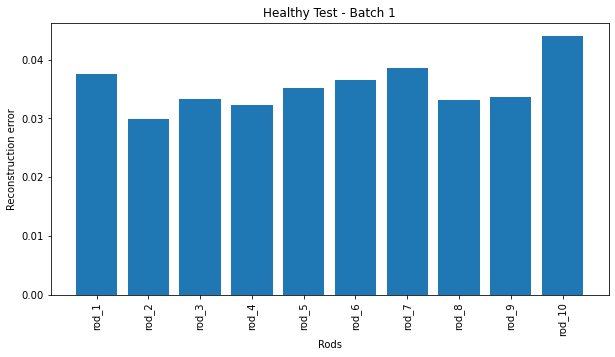

In [8]:
# Calculate reconstruction error for each variable on test data
test_data_pred = AE_model.predict(X_test_ind_a)
test_data_recon_error = np.abs(X_test_ind_a - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), col_list, rotation=90)
plt.ylabel('Reconstruction error')
# plt.ylim(0,0.55)
plt.xlabel('Rods')
plt.title('Healthy Test - Batch 1')
plt.show()

15626/15626 [==============================] - 9s 589us/step
Number of anomalies: 230571


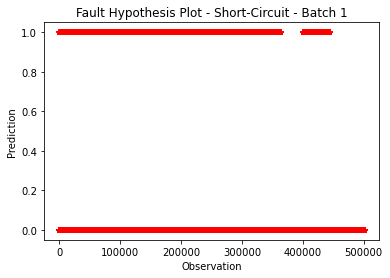

In [9]:
# Evaluate the model
X_pred = AE_model.predict(X_test_ind_S)
mse = np.mean(np.power(X_test_ind_S - X_pred, 2), axis=1)
anomalies = np.where(mse > threshold)[0]
print('Number of anomalies:', len(anomalies))

# Predict Fault
predictions = np.zeros_like(mse)
predictions[mse > threshold] = 1

# Plot Hypothesis Curve
import matplotlib.pyplot as plt
plt.plot(predictions, 'r*')
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('Fault Hypothesis Plot - Short-Circuit - Batch 1')
plt.show()

15626/15626 [==============================] - 9s 585us/step


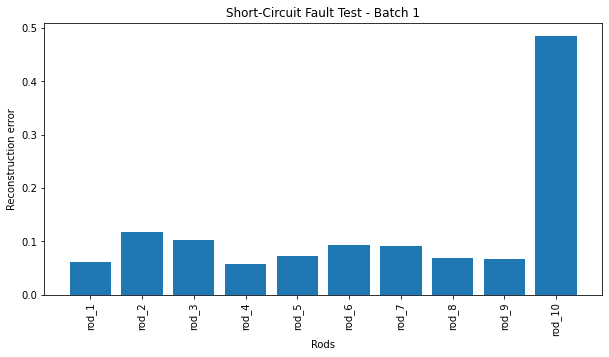

In [10]:
# Calculate reconstruction error for each variable on test data
test_data_pred = AE_model.predict(X_test_ind_S)
test_data_recon_error = np.abs(X_test_ind_S - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)

# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), col_list, rotation=90)
plt.ylabel('Reconstruction error')
# plt.ylim(0,0.6)
plt.xlabel('Rods')
plt.title('Short-Circuit Fault Test - Batch 1')
plt.show()

15626/15626 [==============================] - 11s 689us/step
Number of anomalies: 89079


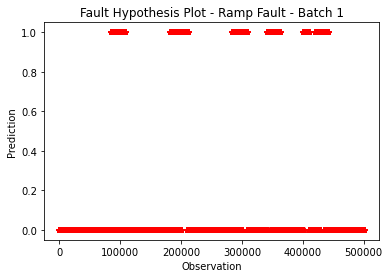

In [11]:
# Evaluate the model
X_pred = AE_model.predict(X_test_ind_L)
mse = np.mean(np.power(X_test_ind_L - X_pred, 2), axis=1)
# threshold = np.percentile(mse, 95)
anomalies = np.where(mse > threshold)[0]
print('Number of anomalies:', len(anomalies))

# Predict Fault
predictions = np.zeros_like(mse)
predictions[mse > threshold] = 1

# Plot Hypothesis Curve
import matplotlib.pyplot as plt
plt.plot(predictions, 'r*')
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('Fault Hypothesis Plot - Ramp Fault - Batch 1')
plt.show()

15626/15626 [==============================] - 11s 685us/step


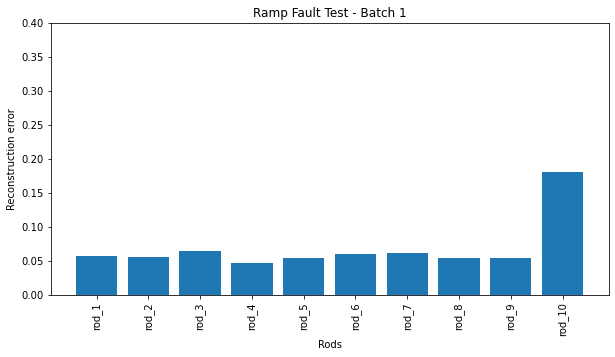

In [12]:
# Calculate reconstruction error for each variable on test data
test_data_pred = AE_model.predict(X_test_ind_L)
test_data_recon_error = np.abs(X_test_ind_L - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)

# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), col_list, rotation=90)
plt.ylabel('Reconstruction error')
plt.xlabel('Rods')
plt.ylim(0,0.4)
plt.title('Ramp Fault Test - Batch 1')
plt.show()

15626/15626 [==============================] - 10s 613us/step
Number of anomalies: 17224


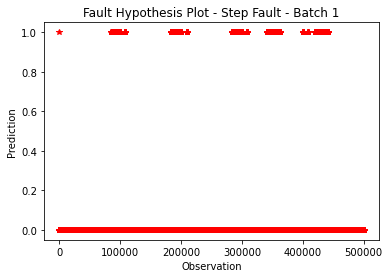

In [13]:
# Evaluate the model
X_pred = AE_model.predict(X_test_ind_LS)
mse = np.mean(np.power(X_test_ind_LS - X_pred, 2), axis=1)
anomalies = np.where(mse > threshold)[0]
print('Number of anomalies:', len(anomalies))

# Predict Fault
predictions = np.zeros_like(mse)
predictions[mse > threshold] = 1

# Plot Hypothesis Curve
import matplotlib.pyplot as plt
plt.plot(predictions, 'r*')
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('Fault Hypothesis Plot - Step Fault - Batch 1')
plt.show()

15626/15626 [==============================] - 11s 705us/step


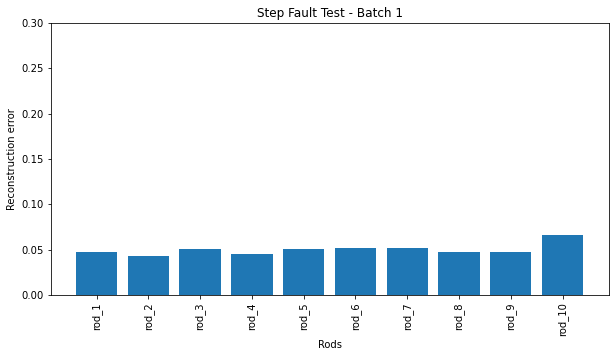

In [14]:
# Calculate reconstruction error for each variable on test data
test_data_pred = AE_model.predict(X_test_ind_LS)
test_data_recon_error = np.abs(X_test_ind_LS - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)

# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), col_list, rotation=90)
plt.ylabel('Reconstruction error')
plt.xlabel('Rods')
plt.ylim(0,0.3)
plt.title('Step Fault Test - Batch 1')
plt.show()

#### Batch 5

In [15]:
healthy_5 = pd.read_csv('T_a5_new.csv',header=None, names=col_list)
short_fault_5 = pd.read_csv('T_S5_new.csv',header=None, names=col_list)
step_fault_5 = pd.read_csv('T_LS5_new.csv',header=None, names=col_list)
ramp_fault_5 = pd.read_csv('T_L5_new.csv',header=None, names=col_list)

In [16]:
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Load and preprocess data
healthy_5=np.array(healthy_5)
X_train_ind = scaler.fit_transform(healthy_5[0:int(0.7*len(healthy_5)),:])
X_test_ind_a = scaler.transform(healthy_5[int(0.7*len(healthy_5)):,:])
X_test_ind_S = scaler.transform(np.array(short_fault_5))
X_test_ind_LS = scaler.transform(np.array(step_fault_5))
X_test_ind_L = scaler.transform(np.array(ramp_fault_5))

In [17]:
AE_model.fit(X_train_ind, X_train_ind, epochs=6, batch_size=64, validation_split=0.2, callbacks = [checkpoint])

Epoch 1/6
4375/4375 [==============================] - 5s 1ms/step - loss: 0.0051 - val_loss: 0.0095
Epoch 2/6
4375/4375 [==============================] - 5s 1ms/step - loss: 0.0048 - val_loss: 0.0095
Epoch 3/6
4375/4375 [==============================] - 5s 1ms/step - loss: 0.0047 - val_loss: 0.0095
Epoch 4/6
4375/4375 [==============================] - 5s 1ms/step - loss: 0.0047 - val_loss: 0.0095
Epoch 5/6
4375/4375 [==============================] - 5s 1ms/step - loss: 0.0046 - val_loss: 0.0095
Epoch 6/6
4375/4375 [==============================] - 5s 1ms/step - loss: 0.0046 - val_loss: 0.0096


4688/4688 [==============================] - 3s 607us/step
Number of anomalies: 7500


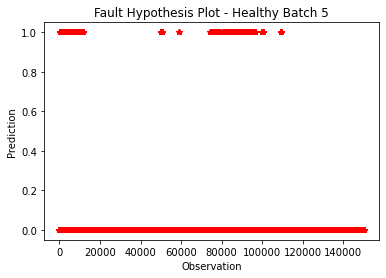

In [18]:
# Evaluate the model
X_pred = AE_model.predict(X_test_ind_a)
mse = np.mean(np.power(X_test_ind_a - X_pred, 2), axis=1)
threshold = np.percentile(mse, 95)
anomalies = np.where(mse > threshold)[0]
print('Number of anomalies:', len(anomalies))

# Predict Fault
predictions = np.zeros_like(mse)
predictions[mse > threshold] = 1

# Plot Hypothesis Curve
import matplotlib.pyplot as plt
plt.plot(predictions, 'r*')
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('Fault Hypothesis Plot - Healthy Batch 5')
plt.show()

4688/4688 [==============================] - 3s 680us/step


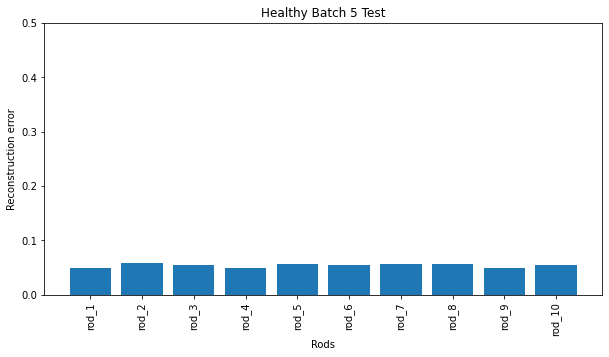

In [19]:
# Calculate reconstruction error for each variable on test data
test_data_pred = AE_model.predict(X_test_ind_a)
test_data_recon_error = np.abs(X_test_ind_a - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)

# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), col_list, rotation=90)
plt.ylabel('Reconstruction error')
plt.xlabel('Rods')
plt.ylim(0,0.5)
plt.title('Healthy Batch 5 Test')
plt.show()

15626/15626 [==============================] - 10s 638us/step
Number of anomalies: 225432


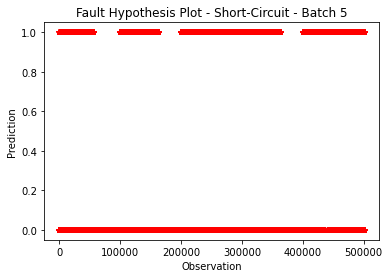

In [20]:
# Evaluate the model
X_pred = AE_model.predict(X_test_ind_S)
mse = np.mean(np.power(X_test_ind_S - X_pred, 2), axis=1)
anomalies = np.where(mse > threshold)[0]
print('Number of anomalies:', len(anomalies))

# Predict Fault
predictions = np.zeros_like(mse)
predictions[mse > threshold] = 1

# Plot Hypothesis Curve
import matplotlib.pyplot as plt
plt.plot(predictions, 'r*')
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('Fault Hypothesis Plot - Short-Circuit - Batch 5')
plt.show()

15626/15626 [==============================] - 10s 642us/step


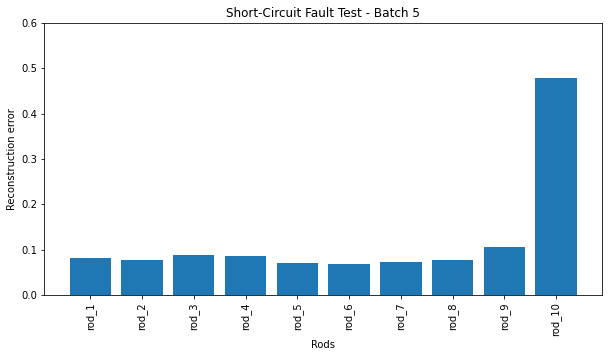

In [21]:
# Calculate reconstruction error for each variable on test data
test_data_pred = AE_model.predict(X_test_ind_S)
test_data_recon_error = np.abs(X_test_ind_S - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)

# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), col_list, rotation=90)
plt.ylabel('Reconstruction error')
plt.xlabel('Rods')
plt.ylim(0,0.6)
plt.title('Short-Circuit Fault Test - Batch 5')
plt.show()

15626/15626 [==============================] - 10s 618us/step
Number of anomalies: 95168


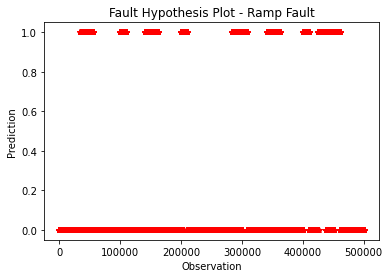

In [22]:
# Evaluate the model
X_pred = AE_model.predict(X_test_ind_L)
mse = np.mean(np.power(X_test_ind_L - X_pred, 2), axis=1)
anomalies = np.where(mse > threshold)[0]
print('Number of anomalies:', len(anomalies))

# Predict Fault
predictions = np.zeros_like(mse)
predictions[mse > threshold] = 1

# Plot Hypothesis Curve
import matplotlib.pyplot as plt
plt.plot(predictions, 'r*')
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('Fault Hypothesis Plot - Ramp Fault')
plt.show()

15626/15626 [==============================] - 9s 586us/step


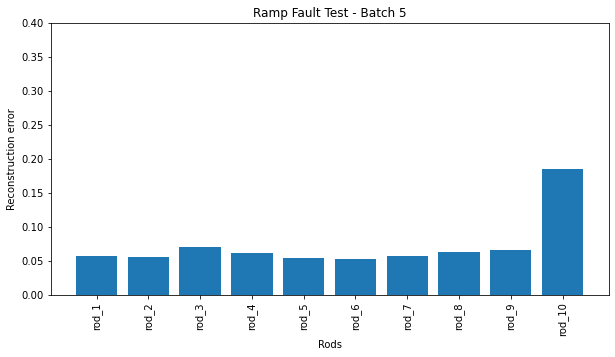

In [23]:
# Calculate reconstruction error for each variable on test data
test_data_pred = AE_model.predict(X_test_ind_L)
test_data_recon_error = np.abs(X_test_ind_L - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)

# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), col_list, rotation=90)
plt.ylabel('Reconstruction error')
plt.xlabel('Rods')
plt.ylim(0,0.4)
plt.title('Ramp Fault Test - Batch 5')
plt.show()

15626/15626 [==============================] - 9s 593us/step
Number of anomalies: 20265


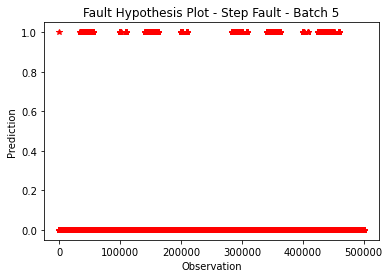

In [24]:
# Evaluate the model
X_pred = AE_model.predict(X_test_ind_LS)
mse = np.mean(np.power(X_test_ind_LS - X_pred, 2), axis=1)
anomalies = np.where(mse > threshold)[0]
print('Number of anomalies:', len(anomalies))

# Predict Fault
predictions = np.zeros_like(mse)
predictions[mse > threshold] = 1

# Plot Hypothesis Curve
import matplotlib.pyplot as plt
plt.plot(predictions, 'r*')
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('Fault Hypothesis Plot - Step Fault - Batch 5')
plt.show()

15626/15626 [==============================] - 9s 579us/step


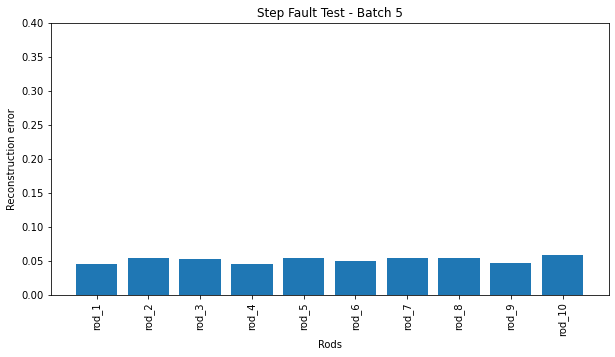

In [25]:
# Calculate reconstruction error for each variable on test data
test_data_pred = AE_model.predict(X_test_ind_LS)
test_data_recon_error = np.abs(X_test_ind_LS - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)

# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), col_list, rotation=90)
plt.ylabel('Reconstruction error')
plt.xlabel('Rods')
plt.ylim(0,0.4)
plt.title('Step Fault Test - Batch 5')
plt.show()

### Combined Batch Test

In [26]:
# Filter the list to keep only healthy torque files that start with 'T_a_'
files_ = [f for f in files if f.startswith('T_a')]

col_list = ['rod_1','rod_2','rod_3','rod_4','rod_5','rod_6','rod_7','rod_8','rod_9','rod_10']

# Load the files into a DataFrame
healthy_torque_df = pd.concat([pd.read_csv(f,header=None, names=col_list) for f in files_], ignore_index=True)
print(healthy_torque_df.shape)
healthy_torque_df.head()

(3000006, 10)


,rod_1,rod_2,rod_3,rod_4,rod_5,rod_6,rod_7,rod_8,rod_9,rod_10
0,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21
1,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19
2,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14
3,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13
4,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13


In [27]:
# Filter the list to keep only short-circuit torque files that start with 'T_S_'
files_ = [f for f in files if f.startswith('T_S')]

col_list = ['rod_1','rod_2','rod_3','rod_4','rod_5','rod_6','rod_7','rod_8','rod_9','rod_10']

# Load the files into a DataFrame
short_torque_df = pd.concat([pd.read_csv(f,header=None, names=col_list) for f in files_], ignore_index=True)
print(short_torque_df.shape)
short_torque_df.head()

(3000006, 10)


,rod_1,rod_2,rod_3,rod_4,rod_5,rod_6,rod_7,rod_8,rod_9,rod_10
0,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,1.456300e-13
1,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,3.136300e-12
2,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,8.327500e-12
3,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.566000e-11
4,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,2.516600e-11


In [28]:
# Filter the list to keep only step fault torque files that start with 'T_LS'
files_ = [f for f in files if f.startswith('T_LS')]

col_list = ['rod_1','rod_2','rod_3','rod_4','rod_5','rod_6','rod_7','rod_8','rod_9','rod_10']

# Load the files into a DataFrame
step_torque_df = pd.concat([pd.read_csv(f,header=None, names=col_list) for f in files_], ignore_index=True)
print(step_torque_df.shape)
step_torque_df.head()

(3000006, 10)


,rod_1,rod_2,rod_3,rod_4,rod_5,rod_6,rod_7,rod_8,rod_9,rod_10
0,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21
1,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19
2,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14
3,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13
4,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13


In [29]:
# Filter the list to keep only Ramp fault torque files that start with 'T_L_'
files_ = [f for f in files if f.startswith('T_L')]
files_ = [f for f in files_ if not f.startswith('T_LS')]
col_list = ['rod_1','rod_2','rod_3','rod_4','rod_5','rod_6','rod_7','rod_8','rod_9','rod_10']

# Load the files into a DataFrame
ramp_torque_df = pd.concat([pd.read_csv(f,header=None, names=col_list) for f in files_], ignore_index=True)
print(ramp_torque_df.shape)
ramp_torque_df.head()

(3000006, 10)


,rod_1,rod_2,rod_3,rod_4,rod_5,rod_6,rod_7,rod_8,rod_9,rod_10
0,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21,3.051400e-21
1,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19,-3.414800e-19
2,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14,5.825400e-14
3,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13,1.663400e-13
4,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13,3.378900e-13


In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Load and preprocess data
healthy_torque=np.array(healthy_torque_df)
X_train = scaler.fit_transform(healthy_torque[0:int(0.7*len(healthy_torque)),:])
X_test_a = scaler.transform(healthy_torque[int(0.7*len(healthy_torque)):,:])
X_test_s = scaler.transform(np.array(short_torque_df))

# Define the model
input_dim = X_train.shape[1]
latent_dim = 2
model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(input_dim,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(latent_dim, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mse')


In [31]:
# Train the model
model.fit(X_train, X_train, epochs=6, batch_size=64, validation_split=0.2)

Epoch 1/6
26251/26251 [==============================] - 31s 1ms/step - loss: 0.0146 - val_loss: 0.0178
Epoch 2/6
26251/26251 [==============================] - 30s 1ms/step - loss: 0.0087 - val_loss: 0.0135
Epoch 3/6
26251/26251 [==============================] - 31s 1ms/step - loss: 0.0086 - val_loss: 0.0136
Epoch 4/6
26251/26251 [==============================] - 32s 1ms/step - loss: 0.0086 - val_loss: 0.0134
Epoch 5/6
26251/26251 [==============================] - 32s 1ms/step - loss: 0.0086 - val_loss: 0.0134
Epoch 6/6
26251/26251 [==============================] - 31s 1ms/step - loss: 0.0086 - val_loss: 0.0134


28126/28126 [==============================] - 18s 649us/step
Number of anomalies: 45001


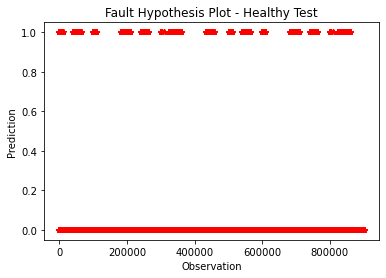

In [32]:
# Evaluate the model
X_pred = model.predict(X_test_a)
mse = np.mean(np.power(X_test_a - X_pred, 2), axis=1)
threshold = np.percentile(mse, 95)
anomalies = np.where(mse > threshold)[0]
print('Number of anomalies:', len(anomalies))

# Predict Fault
predictions = np.zeros_like(mse)
predictions[mse > threshold] = 1

# Plot Hypothesis Curve
import matplotlib.pyplot as plt
plt.plot(predictions, 'r*')
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('Fault Hypothesis Plot - Healthy Test')
plt.show()

28126/28126 [==============================] - 18s 641us/step


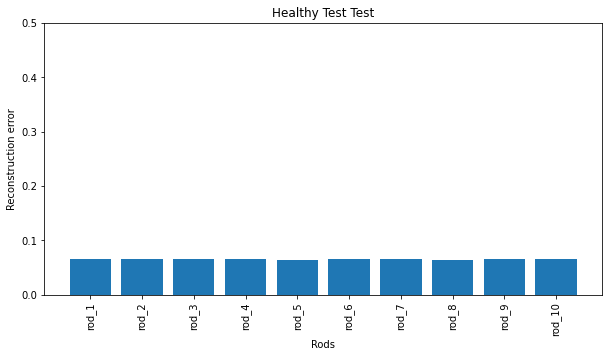

In [33]:
# Calculate reconstruction error for each variable on test data
test_data_pred = model.predict(X_test_a)
test_data_recon_error = np.abs(X_test_a - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)
# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), ramp_torque_df.columns, rotation=90)
plt.ylabel('Reconstruction error')
plt.xlabel('Rods')
plt.ylim(0,0.5)
plt.title('Healthy Test Test')
plt.show()

In [34]:
col_threshold_a = np.percentile(variable_recon_error, 95)
# anomalies = np.where(variable_recon_error > col_threshold_a)[0]

93751/93751 [==============================] - 58s 616us/step
Number of anomalies: 1536346


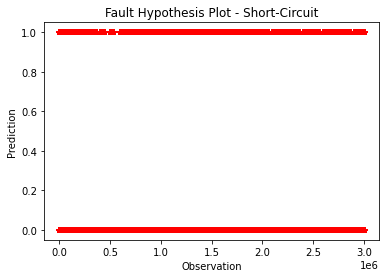

In [35]:
# Evaluate the model
X_pred = model.predict(X_test_s)
mse = np.mean(np.power(X_test_s - X_pred, 2), axis=1)
# threshold = np.percentile(mse, 95)
anomalies = np.where(mse > threshold)[0]
print('Number of anomalies:', len(anomalies))

# Predict Fault
predictions = np.zeros_like(mse)
predictions[mse > threshold] = 1

# Plot Hypothesis Curve
import matplotlib.pyplot as plt
plt.plot(predictions, 'r*')
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('Fault Hypothesis Plot - Short-Circuit')
plt.show()

93751/93751 [==============================] - 62s 663us/step


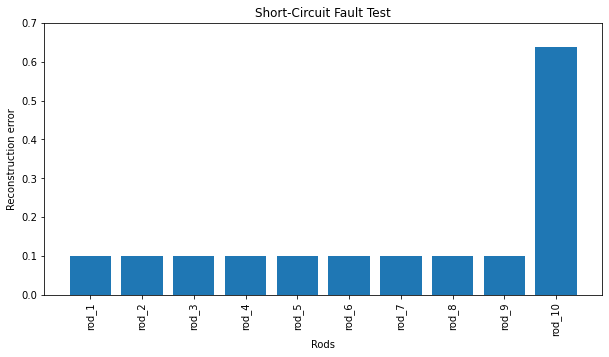

In [36]:
# Calculate reconstruction error for each variable on test data
test_data_pred = model.predict(X_test_s)
test_data_recon_error = np.abs(X_test_s - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)
# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), ramp_torque_df.columns, rotation=90)
plt.ylabel('Reconstruction error')
plt.xlabel('Rods')
plt.ylim(0,0.7)
plt.title('Short-Circuit Fault Test')
plt.show()

93751/93751 [==============================] - 61s 649us/step
Number of anomalies: 571292


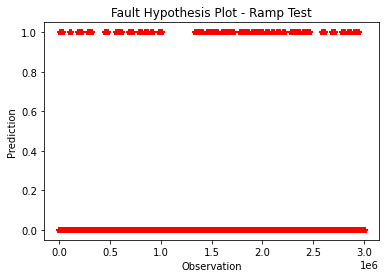

In [37]:
X_test_ramp = scaler.transform(np.array(ramp_torque_df))

# Evaluate the model
X_pred = model.predict(X_test_ramp)
mse = np.mean(np.power(X_test_ramp - X_pred, 2), axis=1)
# threshold = np.percentile(mse, 95)
anomalies = np.where(mse > threshold)[0]
print('Number of anomalies:', len(anomalies))

# Predict Fault
predictions = np.zeros_like(mse)
predictions[mse > threshold] = 1

# Plot Hypothesis Curve
import matplotlib.pyplot as plt
plt.plot(predictions, 'r*')
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('Fault Hypothesis Plot - Ramp Test')
plt.show()

93751/93751 [==============================] - 61s 650us/step


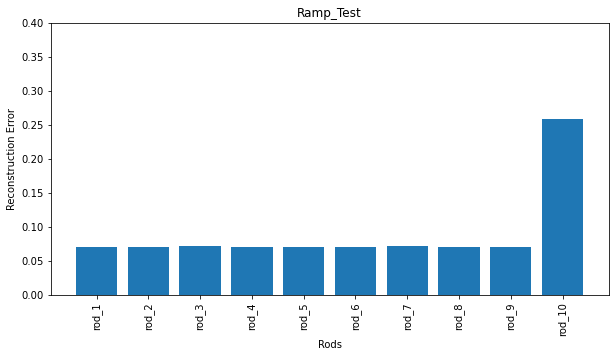

In [38]:
# Calculate reconstruction error for each variable on test data
test_data_pred = model.predict(X_test_ramp)
test_data_recon_error = np.abs(X_test_ramp - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)

# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), ramp_torque_df.columns, rotation=90)
plt.ylabel('Reconstruction Error')
plt.xlabel('Rods')
plt.ylim(0,0.4)
plt.title('Ramp_Test')
plt.show()

93751/93751 [==============================] - 60s 636us/step
Number of anomalies: 230055


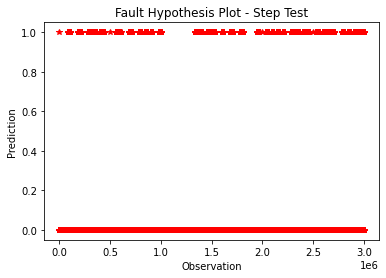

In [39]:
X_test_step = scaler.transform(np.array(step_torque_df))

# Evaluate the model
X_pred = model.predict(X_test_step)
mse = np.mean(np.power(X_test_step - X_pred, 2), axis=1)
# threshold = np.percentile(mse, 95)
anomalies = np.where(mse > threshold)[0]
print('Number of anomalies:', len(anomalies))

# Predict Fault
predictions = np.zeros_like(mse)
predictions[mse > threshold] = 1

# Plot Hypothesis Curve
import matplotlib.pyplot as plt
plt.plot(predictions, 'r*')
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('Fault Hypothesis Plot - Step Test')
plt.show()

93751/93751 [==============================] - 54s 577us/step


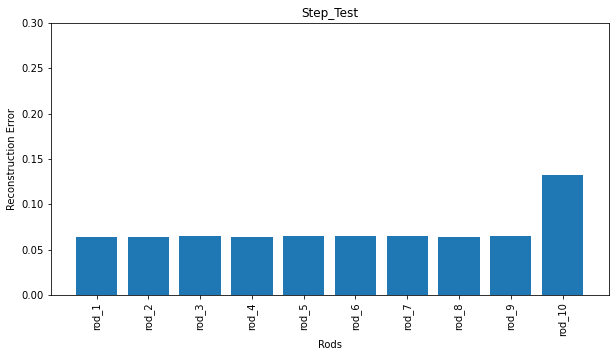

In [40]:
# Calculate reconstruction error for each variable on test data
test_data_pred = model.predict(X_test_step)
test_data_recon_error = np.abs(X_test_step - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)

# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), ramp_torque_df.columns, rotation=90)
plt.ylabel('Reconstruction Error')
plt.xlabel('Rods')
plt.ylim(0,0.3)
plt.title('Step_Test')
plt.show()

### Multiple Faults in a Bank

In [41]:
X_test_s[:,9:10].shape

(3000006, 1)

In [42]:
X_ramp_step = np.concatenate([X_test_s[:,0:4], X_test_ramp[:,9:10],X_test_s[:,5:9],X_test_step[:,9:10]], axis=1)
X_ramp_step.shape

(3000006, 10)

93751/93751 [==============================] - 57s 608us/step


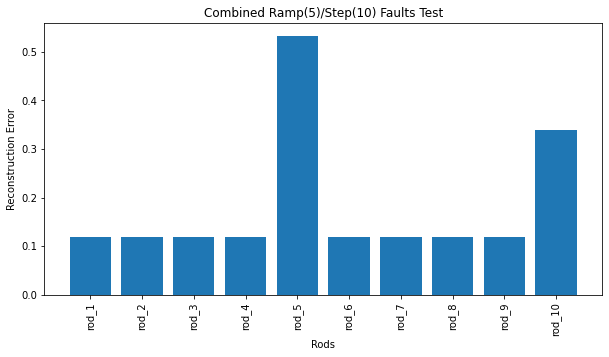

In [43]:
# Calculate reconstruction error for each variable on test data
test_data_pred = model.predict(X_ramp_step)
test_data_recon_error = np.abs(X_ramp_step - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)

# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), ramp_torque_df.columns, rotation=90)
plt.ylabel('Reconstruction Error')
plt.xlabel('Rods')
plt.title('Combined Ramp(5)/Step(10) Faults Test')
plt.show()

Number of anomalies: 2


Text(0.5, 1.0, 'Combined Ramp(5)/Step(10) Faults Test')

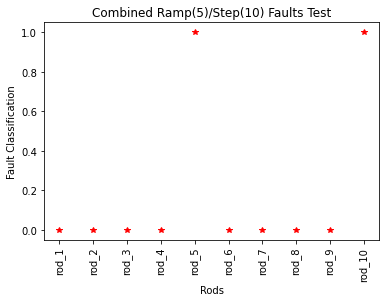

In [44]:
col_threshold = np.percentile(variable_recon_error, 80)
anomalies = np.where(variable_recon_error > col_threshold)[0]
print('Number of anomalies:', len(anomalies))
predictions = np.zeros_like(variable_recon_error)
predictions[variable_recon_error > col_threshold] = 1
plt.plot(range(1, input_dim+1), predictions,'r*')
plt.xticks(range(1, input_dim+1), ramp_torque_df.columns, rotation=90)
plt.ylabel('Fault Classification')
plt.xlabel('Rods')
# plt.ylim(0,1)
plt.title('Combined Ramp(5)/Step(10) Faults Test')

In [45]:
X_short_ramp_step = np.concatenate([X_test_s[:,9:10], X_test_s[:,0:3], X_test_ramp[:,9:10],X_test_s[:,5:9],X_test_step[:,9:10]], axis=1)
X_short_ramp_step.shape

(3000006, 10)

93751/93751 [==============================] - 57s 604us/step


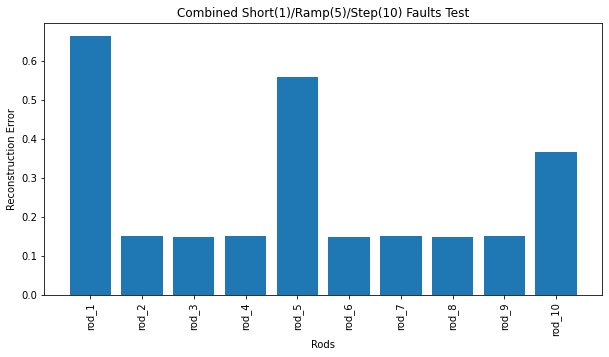

In [46]:
# Calculate reconstruction error for each variable on test data
test_data_pred = model.predict(X_short_ramp_step)
test_data_recon_error = np.abs(X_short_ramp_step - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)

# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), ramp_torque_df.columns, rotation=90)
plt.ylabel('Reconstruction Error')
plt.xlabel('Rods')
plt.title('Combined Short(1)/Ramp(5)/Step(10) Faults Test')
plt.show()

Number of anomalies: 3


Text(0.5, 1.0, 'Combined Short(1)/Ramp(5)/Step(10) Faults Test')

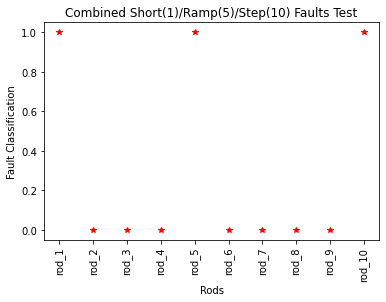

In [47]:
col_threshold = np.percentile(variable_recon_error, 70)
anomalies = np.where(variable_recon_error > col_threshold)[0]
print('Number of anomalies:', len(anomalies))
predictions = np.zeros_like(variable_recon_error)
predictions[variable_recon_error > col_threshold] = 1
plt.plot(range(1, input_dim+1), predictions,'r*')
plt.xticks(range(1, input_dim+1), ramp_torque_df.columns, rotation=90)
plt.ylabel('Fault Classification')
plt.xlabel('Rods')
# plt.ylim(0,1)
plt.title('Combined Short(1)/Ramp(5)/Step(10) Faults Test')

## Minimum Required Effective Variables

### 3 Rods

In [48]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Load and preprocess data
healthy_torque=np.array(healthy_torque_df)
X_train_m3 = scaler.fit_transform(healthy_torque[0:int(0.7*len(healthy_torque)),7:10])
X_test_m3_a = scaler.transform(healthy_torque[int(0.7*len(healthy_torque)):,7:10])
X_test_m3_s = scaler.transform(np.array(short_torque_df)[:,7:10])
X_test_m3_ramp = scaler.transform(np.array(ramp_torque_df)[:,7:10])
X_test_m3_step = scaler.transform(np.array(step_torque_df)[:,7:10])


# Define the model
input_dim = X_train_m3.shape[1]
latent_dim = 1
model_3 = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(input_dim,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(latent_dim, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

# Compile the model
model_3.compile(optimizer='adam', loss='mse')


In [49]:
model_3.fit(X_train_m3, X_train_m3, epochs=6, batch_size=64, validation_split=0.2)

Epoch 1/6
26251/26251 [==============================] - 32s 1ms/step - loss: 0.0112 - val_loss: 0.0121
Epoch 2/6
26251/26251 [==============================] - 29s 1ms/step - loss: 0.0065 - val_loss: 0.0123
Epoch 3/6
26251/26251 [==============================] - 31s 1ms/step - loss: 0.0064 - val_loss: 0.0117
Epoch 4/6
26251/26251 [==============================] - 32s 1ms/step - loss: 0.0064 - val_loss: 0.0115
Epoch 5/6
26251/26251 [==============================] - 31s 1ms/step - loss: 0.0064 - val_loss: 0.0114
Epoch 6/6
26251/26251 [==============================] - 31s 1ms/step - loss: 0.0064 - val_loss: 0.0115


28126/28126 [==============================] - 19s 656us/step


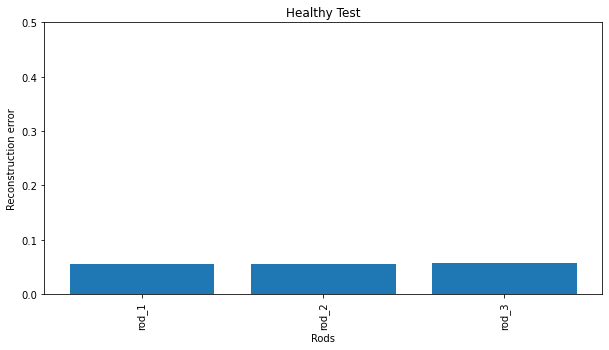

In [50]:
# Calculate reconstruction error for each variable on test data
test_data_pred = model_3.predict(X_test_m3_a)
test_data_recon_error = np.abs(X_test_m3_a - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)
# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), ramp_torque_df.columns[0:3], rotation=90)
plt.ylabel('Reconstruction error')
plt.xlabel('Rods')
plt.ylim(0,0.5)
plt.title('Healthy Test')
plt.show()

93751/93751 [==============================] - 60s 635us/step


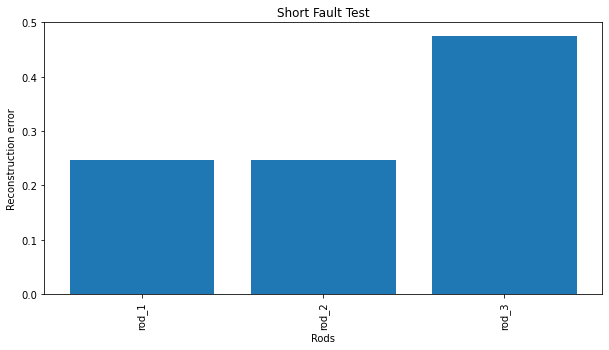

In [51]:
test_data_pred = model_3.predict(X_test_m3_s)
test_data_recon_error = np.abs(X_test_m3_s - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)
# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), ramp_torque_df.columns[0:3], rotation=90)
plt.ylabel('Reconstruction error')
plt.xlabel('Rods')
plt.ylim(0,0.5)
plt.title('Short Fault Test')
plt.show()

93751/93751 [==============================] - 60s 634us/step


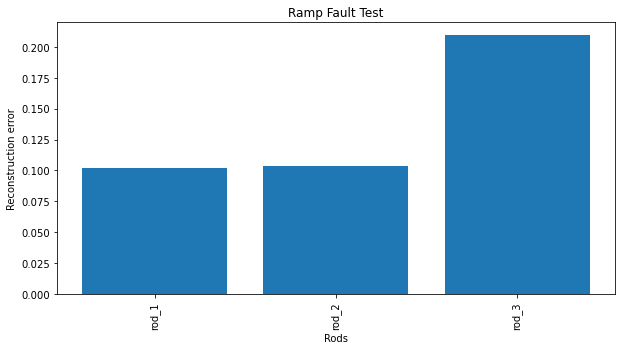

In [52]:
test_data_pred = model_3.predict(X_test_m3_ramp)
test_data_recon_error = np.abs(X_test_m3_ramp - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)
# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), ramp_torque_df.columns[0:3], rotation=90)
plt.ylabel('Reconstruction error')
plt.xlabel('Rods')
# plt.ylim(0,0.5)
plt.title('Ramp Fault Test')
plt.show()

93751/93751 [==============================] - 59s 626us/step


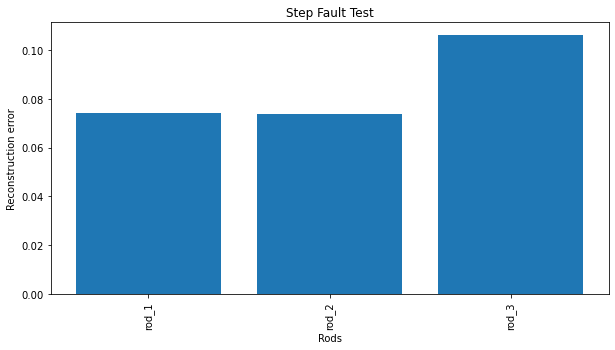

In [53]:
test_data_pred = model_3.predict(X_test_m3_step)
test_data_recon_error = np.abs(X_test_m3_step - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)
# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), ramp_torque_df.columns[0:3], rotation=90)
plt.ylabel('Reconstruction error')
plt.xlabel('Rods')
# plt.ylim(0,0.5)
plt.title('Step Fault Test')
plt.show()

### 2 Rods

In [54]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Load and preprocess data
healthy_torque=np.array(healthy_torque_df)
X_train_m2 = scaler.fit_transform(healthy_torque[0:int(0.7*len(healthy_torque)),8:10])
X_test_m2_a = scaler.transform(healthy_torque[int(0.7*len(healthy_torque)):,8:10])
X_test_m2_s = scaler.transform(np.array(short_torque_df)[:,8:10])
X_test_m2_ramp = scaler.transform(np.array(ramp_torque_df)[:,8:10])
X_test_m2_step = scaler.transform(np.array(step_torque_df)[:,8:10])


# Define the model
input_dim = X_train_m2.shape[1]
latent_dim = 1
model_4 = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(input_dim,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(latent_dim, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

# Compile the model
model_4.compile(optimizer='adam', loss='mse')


In [55]:
model_4.fit(X_train_m2, X_train_m2, epochs=6, batch_size=64, validation_split=0.2)

Epoch 1/6
26251/26251 [==============================] - 32s 1ms/step - loss: 0.0106 - val_loss: 0.0085
Epoch 2/6
26251/26251 [==============================] - 30s 1ms/step - loss: 0.0050 - val_loss: 0.0115
Epoch 3/6
26251/26251 [==============================] - 30s 1ms/step - loss: 0.0050 - val_loss: 0.0081
Epoch 4/6
26251/26251 [==============================] - 30s 1ms/step - loss: 0.0050 - val_loss: 0.0081
Epoch 5/6
26251/26251 [==============================] - 30s 1ms/step - loss: 0.0050 - val_loss: 0.0081
Epoch 6/6
26251/26251 [==============================] - 32s 1ms/step - loss: 0.0050 - val_loss: 0.0081


28126/28126 [==============================] - 18s 645us/step


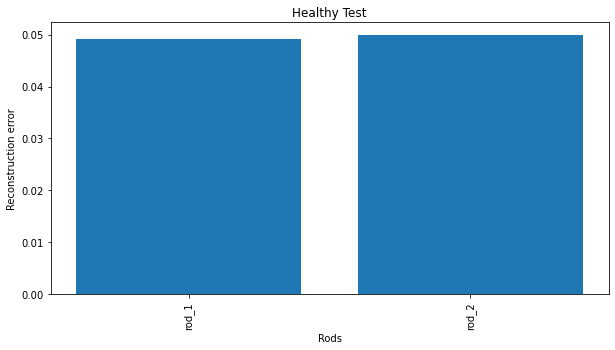

In [56]:
# Calculate reconstruction error for each variable on test data
test_data_pred = model_4.predict(X_test_m2_a)
test_data_recon_error = np.abs(X_test_m2_a - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)
# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), ramp_torque_df.columns[0:2], rotation=90)
plt.ylabel('Reconstruction error')
plt.xlabel('Rods')
# plt.ylim(0,0.5)
plt.title('Healthy Test')
plt.show()

93751/93751 [==============================] - 62s 663us/step


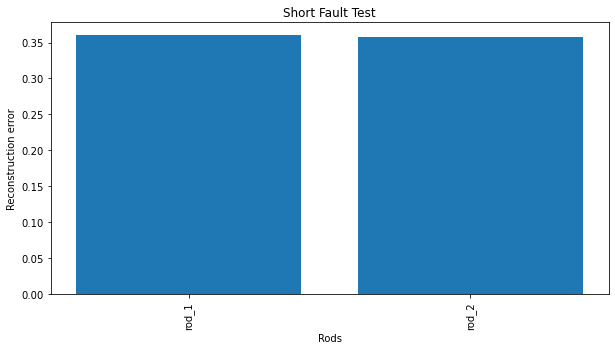

In [57]:
test_data_pred = model_4.predict(X_test_m2_s)
test_data_recon_error = np.abs(X_test_m2_s - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)
# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), ramp_torque_df.columns[0:2], rotation=90)
plt.ylabel('Reconstruction error')
plt.xlabel('Rods')
# plt.ylim(0,0.5)
plt.title('Short Fault Test')
plt.show()

93751/93751 [==============================] - 62s 666us/step


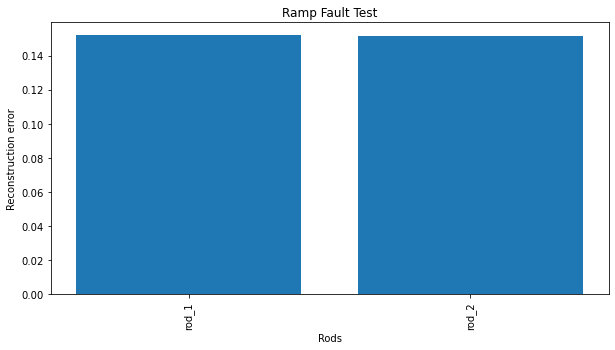

In [58]:
test_data_pred = model_4.predict(X_test_m2_ramp)
test_data_recon_error = np.abs(X_test_m2_ramp - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)
# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), ramp_torque_df.columns[0:2], rotation=90)
plt.ylabel('Reconstruction error')
plt.xlabel('Rods')
# plt.ylim(0,0.5)
plt.title('Ramp Fault Test')
plt.show()

93751/93751 [==============================] - 62s 658us/step


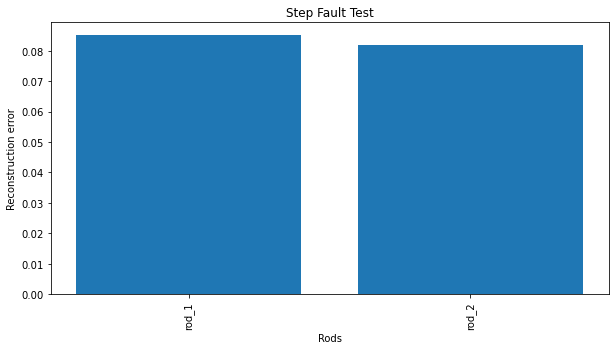

In [59]:
test_data_pred = model_4.predict(X_test_m2_step)
test_data_recon_error = np.abs(X_test_m2_step - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)
# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), ramp_torque_df.columns[0:2], rotation=90)
plt.ylabel('Reconstruction error')
plt.xlabel('Rods')
# plt.ylim(0,0.5)
plt.title('Step Fault Test')
plt.show()

## Using Position Variable

In [60]:
# Filter the list to keep only short-circuit torque files that start with 'T_S_'
files_ = [f for f in files if f.startswith('X_a')]

col_list = ['rod_1','rod_2','rod_3','rod_4','rod_5','rod_6','rod_7','rod_8','rod_9','rod_10']

# Load the files into a DataFrame
healthy_position_df = pd.concat([pd.read_csv(f,header=None, names=col_list) for f in files_], ignore_index=True)
print(healthy_position_df.shape)
healthy_position_df.head()

(3000006, 10)


,rod_1,rod_2,rod_3,rod_4,rod_5,rod_6,rod_7,rod_8,rod_9,rod_10
0,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811
1,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811
2,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811
3,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811
4,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811


In [61]:
# Filter the list to keep only short-circuit torque files that start with 'X_S_'
files_ = [f for f in files if f.startswith('X_S')]

col_list = ['rod_1','rod_2','rod_3','rod_4','rod_5','rod_6','rod_7','rod_8','rod_9','rod_10']

# Load the files into a DataFrame
short_position_df = pd.concat([pd.read_csv(f,header=None, names=col_list) for f in files_], ignore_index=True)
print(short_position_df.shape)
short_position_df.head()

(3000006, 10)


,rod_1,rod_2,rod_3,rod_4,rod_5,rod_6,rod_7,rod_8,rod_9,rod_10
0,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703
1,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703
2,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703
3,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703
4,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703


In [62]:
# Filter the list to keep only short-circuit torque files that start with 'X_LS'
files_ = [f for f in files if f.startswith('X_LS')]

col_list = ['rod_1','rod_2','rod_3','rod_4','rod_5','rod_6','rod_7','rod_8','rod_9','rod_10']

# Load the files into a DataFrame
step_position_df = pd.concat([pd.read_csv(f,header=None, names=col_list) for f in files_], ignore_index=True)
print(step_position_df.shape)
step_position_df.head()

(3000006, 10)


,rod_1,rod_2,rod_3,rod_4,rod_5,rod_6,rod_7,rod_8,rod_9,rod_10
0,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703
1,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703
2,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703
3,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703
4,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703,1.703


In [63]:
# Filter the list to keep only Ramp fault torque files that start with 'T_L_'
files_ = [f for f in files if f.startswith('X_L')]
files_ = [f for f in files_ if not f.startswith('X_LS')]
col_list = ['rod_1','rod_2','rod_3','rod_4','rod_5','rod_6','rod_7','rod_8','rod_9','rod_10']

# Load the files into a DataFrame
ramp_position_df = pd.concat([pd.read_csv(f,header=None, names=col_list) for f in files_], ignore_index=True)
print(ramp_position_df.shape)
ramp_position_df.head()

(3000006, 10)


,rod_1,rod_2,rod_3,rod_4,rod_5,rod_6,rod_7,rod_8,rod_9,rod_10
0,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811
1,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811
2,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811
3,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811
4,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811,0.811


In [64]:
# Load and preprocess data

x_train_position = scaler.fit_transform(np.array(healthy_position_df)[0:int(0.7*len(healthy_position_df)),:])
X_test_pos_a = scaler.transform(np.array(healthy_position_df)[int(0.7*len(healthy_position_df)):,:])
x_test_pos_shor = scaler.transform(np.array(short_position_df))
x_test_pos_step = scaler.transform(np.array(step_position_df))
x_test_pos_ramp = scaler.transform(np.array(ramp_position_df))

In [65]:
np.random.seed(42)
# Define the model
input_dim = x_train_position.shape[1]
latent_dim = 2
autoencoder = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(input_dim,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(latent_dim, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

In [66]:
# Train the model
autoencoder.fit(x_train_position, x_train_position, epochs=6, batch_size=64, validation_split = 0.2)

Epoch 1/6
26251/26251 [==============================] - 31s 1ms/step - loss: 0.0232 - val_loss: 0.2106
Epoch 2/6
26251/26251 [==============================] - 30s 1ms/step - loss: 0.0198 - val_loss: 0.1984
Epoch 3/6
26251/26251 [==============================] - 31s 1ms/step - loss: 0.0198 - val_loss: 0.1717
Epoch 4/6
26251/26251 [==============================] - 32s 1ms/step - loss: 0.0198 - val_loss: 0.1525
Epoch 5/6
26251/26251 [==============================] - 31s 1ms/step - loss: 0.0198 - val_loss: 0.1485
Epoch 6/6
26251/26251 [==============================] - 31s 1ms/step - loss: 0.0198 - val_loss: 0.1232


28126/28126 [==============================] - 17s 615us/step
Number of anomalies: 14048


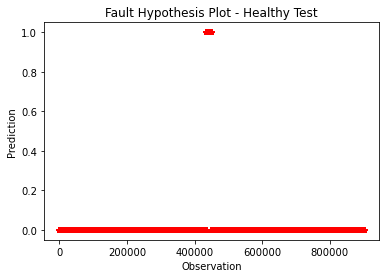

In [75]:
# Evaluate the model
X_pred = autoencoder.predict(X_test_pos_a)
mse = np.mean(np.power(X_test_pos_a - X_pred, 2), axis=1)
threshold = np.percentile(mse, 95)
anomalies = np.where(mse > threshold)[0]
print('Number of anomalies:', len(anomalies))

# Predict Fault
predictions = np.zeros_like(mse)
predictions[mse > threshold] = 1

# Plot Hypothesis Curve
import matplotlib.pyplot as plt
plt.plot(predictions, 'r*')
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('Fault Hypothesis Plot - Healthy Test')
plt.show()

28126/28126 [==============================] - 17s 599us/step


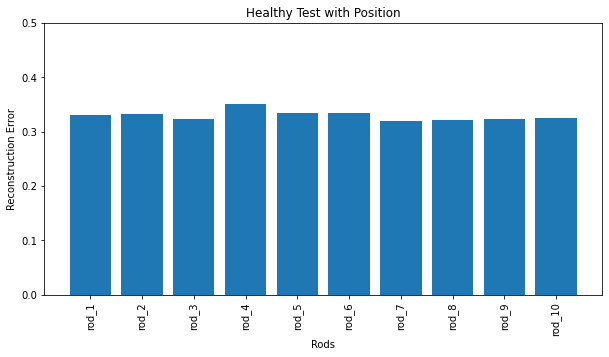

In [76]:
# Calculate reconstruction error for each variable on test data
test_data_pred = autoencoder.predict(X_test_pos_a)
test_data_recon_error = np.abs(X_test_pos_a - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)


# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), ramp_torque_df.columns, rotation=90)
plt.ylabel('Reconstruction Error')
plt.xlabel('Rods')
plt.ylim(0,0.5)
plt.title('Healthy Test with Position')
plt.show()

93751/93751 [==============================] - 56s 594us/step
Number of anomalies: 14452


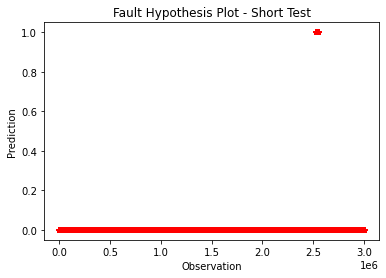

In [77]:
# Evaluate the model
X_pred = autoencoder.predict(x_test_pos_shor)
mse = np.mean(np.power(x_test_pos_shor - X_pred, 2), axis=1)
# threshold = np.percentile(mse, 95)
anomalies = np.where(mse > threshold)[0]
print('Number of anomalies:', len(anomalies))

# Predict Fault
predictions = np.zeros_like(mse)
predictions[mse > threshold] = 1

# Plot Hypothesis Curve
import matplotlib.pyplot as plt
plt.plot(predictions, 'r*')
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('Fault Hypothesis Plot - Short Test')
plt.show()

93751/93751 [==============================] - 59s 627us/step


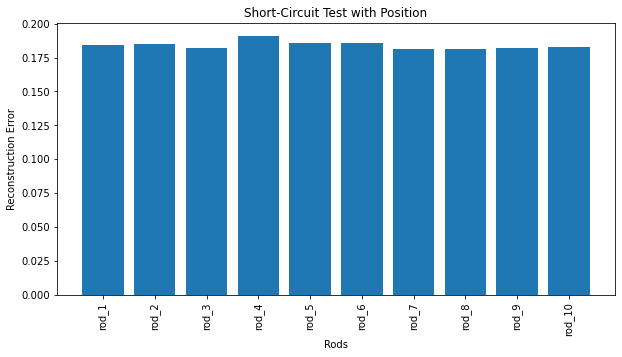

In [78]:
# Calculate reconstruction error for each variable on test data
test_data_pred = autoencoder.predict(x_test_pos_shor)
test_data_recon_error = np.abs(x_test_pos_shor - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)

# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), ramp_torque_df.columns, rotation=90)
plt.ylabel('Reconstruction Error')
plt.xlabel('Rods')
# plt.ylim(0,0.8)
plt.title('Short-Circuit Test with Position')
plt.show()

93751/93751 [==============================] - 59s 628us/step
Number of anomalies: 14064


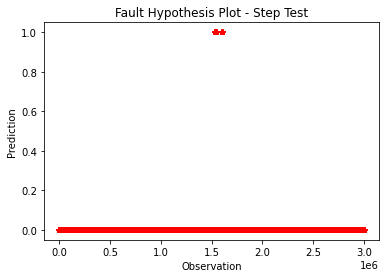

In [79]:
# Evaluate the model
X_pred = autoencoder.predict(x_test_pos_step)
mse = np.mean(np.power(x_test_pos_step - X_pred, 2), axis=1)
# threshold = np.percentile(mse, 95)
anomalies = np.where(mse > threshold)[0]
print('Number of anomalies:', len(anomalies))

# Predict Fault
predictions = np.zeros_like(mse)
predictions[mse > threshold] = 1

# Plot Hypothesis Curve
import matplotlib.pyplot as plt
plt.plot(predictions, 'r*')
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('Fault Hypothesis Plot - Step Test')
plt.show()

93751/93751 [==============================] - 56s 597us/step


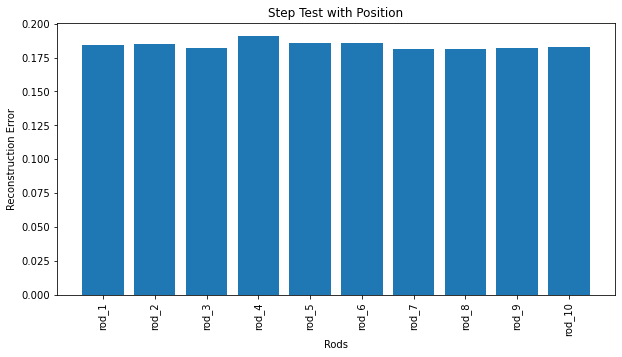

In [80]:
# Calculate reconstruction error for each variable on test data
test_data_pred = autoencoder.predict(x_test_pos_step)
test_data_recon_error = np.abs(x_test_pos_step - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)

# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), ramp_torque_df.columns, rotation=90)
plt.ylabel('Reconstruction Error')
plt.xlabel('Rods')
# plt.ylim(0,0.8)
plt.title('Step Test with Position')
plt.show()

93751/93751 [==============================] - 55s 591us/step
Number of anomalies: 14088


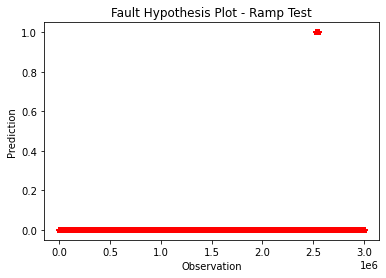

In [81]:
# Evaluate the model
X_pred = autoencoder.predict(x_test_pos_ramp)
mse = np.mean(np.power(x_test_pos_ramp - X_pred, 2), axis=1)
# threshold = np.percentile(mse, 95)
anomalies = np.where(mse > threshold)[0]
print('Number of anomalies:', len(anomalies))

# Predict Fault
predictions = np.zeros_like(mse)
predictions[mse > threshold] = 1

# Plot Hypothesis Curve
import matplotlib.pyplot as plt
plt.plot(predictions, 'r*')
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('Fault Hypothesis Plot - Ramp Test')
plt.show()

93751/93751 [==============================] - 56s 595us/step


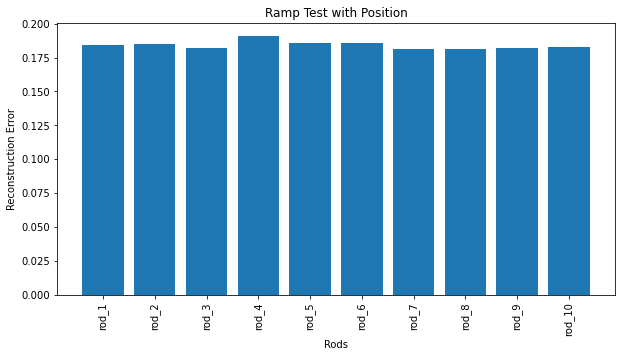

In [82]:
# Calculate reconstruction error for each variable on test data
test_data_pred = autoencoder.predict(x_test_pos_ramp)
test_data_recon_error = np.abs(x_test_pos_ramp - test_data_pred)
variable_recon_error = np.mean(test_data_recon_error, axis=0)

# Visualize reconstruction error per variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(1, input_dim+1), variable_recon_error)
plt.xticks(range(1, input_dim+1), ramp_torque_df.columns, rotation=90)
plt.ylabel('Reconstruction Error')
plt.xlabel('Rods')
# plt.ylim(0,0.8)
plt.title('Ramp Test with Position')
plt.show()